## Scope:

Single-cell imaging data is often noisy. In order to make an accurate estimate of the active kinase concentration, we first want to remove outlier cells from the data set. This example notebook will walk you through how to interact with your data set and remove outlier data using the functions provided. We will use the same process to clean the three data sets that we need.

This method relies heavily on Python classes. The documentation is here (https://docs.python.org/2.7/tutorial/classes.html) for users who wish to learn more about how classes work.

First, we need to import the necessary Python packages to access all of the functions we need.

In [1]:
from __future__ import division
from covertrace.data_array import Sites
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import abspath, dirname, join
%matplotlib inline

Next, we import the functions that will help us access and manipulate the data.

In [2]:
from covertrace import ops_filter
from covertrace import ops_plotter
from covertrace import ops_bool

Finally, we save the location of the data as a variable that we can access later.

In [3]:
data_folder = join(dirname(dirname(dirname(abspath(os.curdir)))), 'covertrack', 'output')

### Clean the first dataset: IL1B stimulation

The *Sites* class provides a convenient interface for handling complex live-cell data. Please take a look at the Github repository for details.
Briefly, it stores all of the single cell traces for various properties and conditions for multiple positions. 

Let's first look at the dataset where the JNK KTR was activated with IL1B. We load the position we want and specify the experimental conditions by setting the variables *sub_folders* and *conditions*. We load these data using the *Sites* command and save it as a *sites* class. The file name 'df.npz' is the default file name, but modified data sets can be saved under different file names and loaded using this command.

In [4]:
parent_folder = join(data_folder, 'IL1B')
sub_folders = ['Pos005', 'Pos006', 'Pos007', 'Pos008',]
conditions = ['IL1B', 'IL1B', 'IL1B', 'IL1B']
sites = Sites(parent_folder, sub_folders, conditions, file_name='df.npz')

The *sites* class stores the data from each position, so typing *sites.Pos005* allows you to access various data for only that position.   
Here, for all the positions, we set the time stamps from 0 min to 140 min for every 5 min, and then save it back to the *sites* class using *sites.position.save()*.

In [5]:
for site in sites:
    site.data.time = np.arange(0, 150, 2.5)  # in minute
    site.save()

Pos008: file_name is updated to arr_modified.npz


Here we introduce two of the most useful methods that will be used for almost any operation. 
The *sites* class stores many properties, including cell size, location, and fluorescent signal. We don't need all of these data now, so we use *sites.set_state* to choose the set we focus to manipulate. Here we use the median cytoplasmic to nuclear ratio of the TRITC signal. If, for example, you wanted to access the median intensity of the nuclear signal, simply replace 'cytoplasm' with 'nuclei' and 'median_ratio' with 'median_intensity.'  
(`print sites.Pos005.data.labels` to see all the properties.)

Next, *sites.iterate* takes the function specified and applies it to all the cells in the data set defined by *sites.set_state*. The functions most often used are stored in the *ops_filter*, *ops_bool*, and *ops_plotter* modules that we imported above, and *iterate* changes its behavior dependent on which module a function is taken from.  In this case, we take *plot_tsplot function* from *ops_plotter* module. When a function from *ops_plotter* is passed to *iterate*, it will draw subplots automatically.  

We use the *partial* function (https://docs.python.org/2/library/functools.html#functools.partial) because there may be times when we want to specify certain function parameters, as you will see in a little bit.   
(Type `ops_plotter.plot_tsplot?` to see a description of what this function does. )

After defining the function simply pass it to *sites.iterate*.

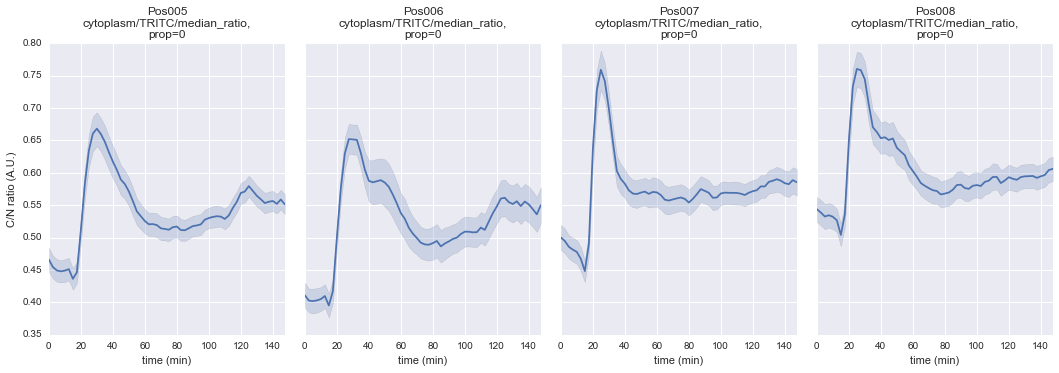

In [55]:
sites.set_state(['cytoplasm', 'TRITC', 'median_ratio'])
plot_tsplot = partial(ops_plotter.plot_tsplot)
fig, axes = sites.iterate(plot_tsplot)
[ax.set_xlabel('time (min)') for ax in axes];
axes[0].set_ylabel('C/N ratio (A.U.)')

Here is the plot generated by *sites.iterate(plot_tsplot)*. It is a plot of the median cytoplasmic to nuclear (C/N) ratio of the TRITC signal. You can see the activation of JNK KTR upon IL1B stimulation.  

Now take a look at the single-cell traces using the function *ops_plotter.plot_all*. Again, we first use *partial* to define the function and then use *sites.iterate* to apply it to the data set.   

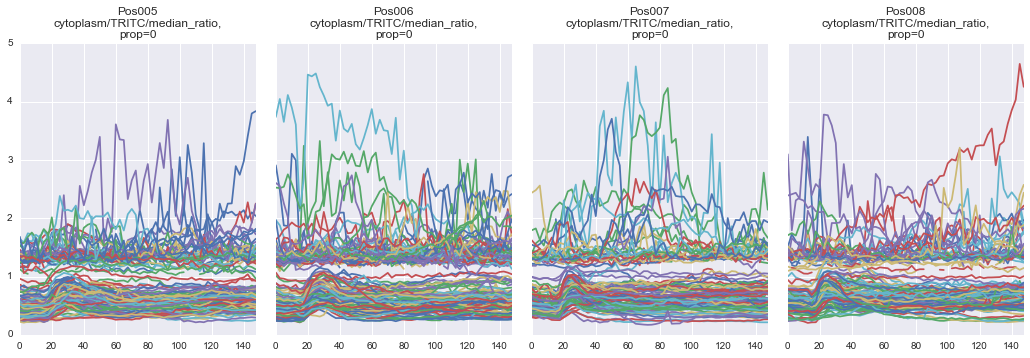

In [7]:
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites.iterate(plot_all)

You can see that the single-cell traces are much noisier than the average trace. 

One typical cause of outliers is cells that express very low amounts of the reporter. Let's take a look at the signal intensity to identify these cells. We use *sites.set_state* to select the data set and then *sites.iterate* to plot. Here we also see the usefulness of the *partial* function, as we can use it to specify having a log-scale on the y-axis.

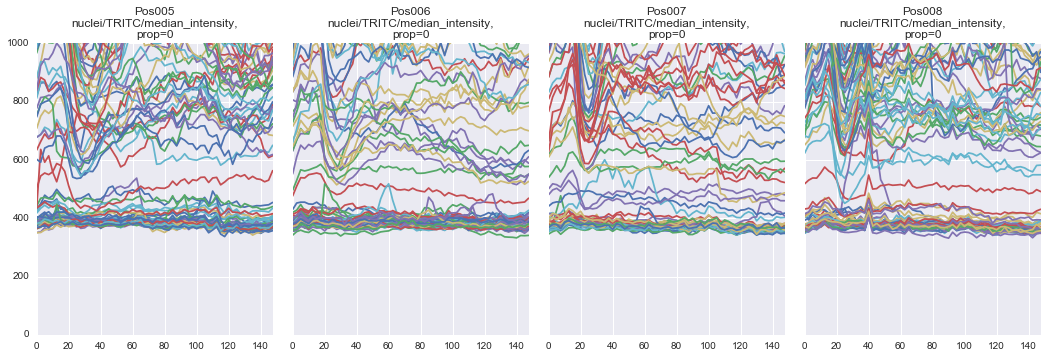

In [8]:
sites.set_state(['nuclei', 'TRITC', 'median_intensity'])
fig, axes = sites.iterate(plot_all)
[ax.set_ylim([0, 1000]) for ax in axes];

Indeed, you can see two distinct populations in terms of the reporter levels in the nuclei. We want to exclude the cells that aren't expressing high amounts of the reporter. The process for doing this is first to assign a 'Property ID' (*pid*) to these cells and then remove all cells with that *pid*.

Let's assign *pid = 1* to all cells with a median intensity less than 500. We've already used *sites.set_state* to select the data, so now we use *ops_bool.filter_frames_by_range* to mark frames with a median intensity less than the specified lower bound. All *ops_bool* functions are used to mark frames that meet certain properties, in this case having a value outside a certain range. Again, *sites.iterate* applies this function to all the frames. Each frame is given its own *pid*, so we use *sites.propagate_prop* to make all the frames the same '*pid* so that they can be removed together. In this case, any cell with a single frame *pid = 1* will have all frames *pid = 1*.

Now when we use *sites.iterate* to plot, it separates the plots based on *pid*.

In [9]:
op = partial(ops_bool.filter_frames_by_range, LOWER=500)
sites.iterate(op, 1)
sites.propagate_prop(pid=1)

Pos008: file_name is updated to arr_modified.npz


We can visually confirm that cells with *pid = 1* have very low expression of TRITC by plotting an overlay on the image from the microscope. The function *sites.images.visualize.mark_prop* is useful for this.

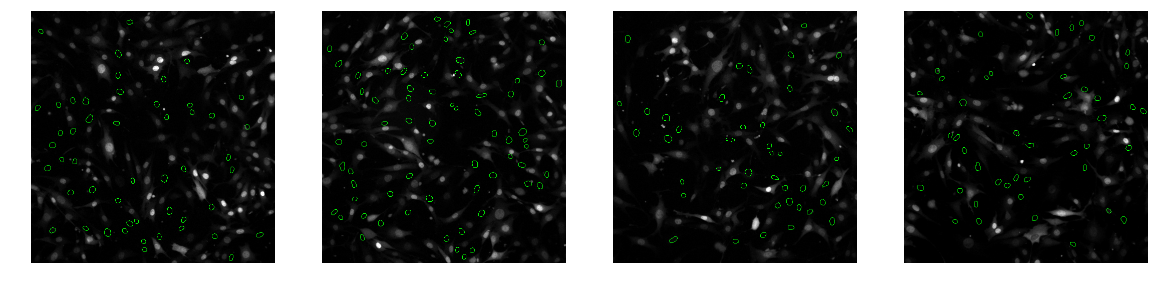

In [10]:
plt.figure(figsize=((20, 5)))
for num, site in enumerate(sites):
    ch_img = site.images.visualize.mark_prop(pid=1)
    plt.subplot(1, 4, num+1)
    plt.imshow(ch_img, cmap='Greys_r')
    plt.axis('off')

We can also check that cells with *pid = 1* have a noisier C/N ratio. Again, this is done using *sites.set_state* to select the proper data and *sites.iterate* to plot.

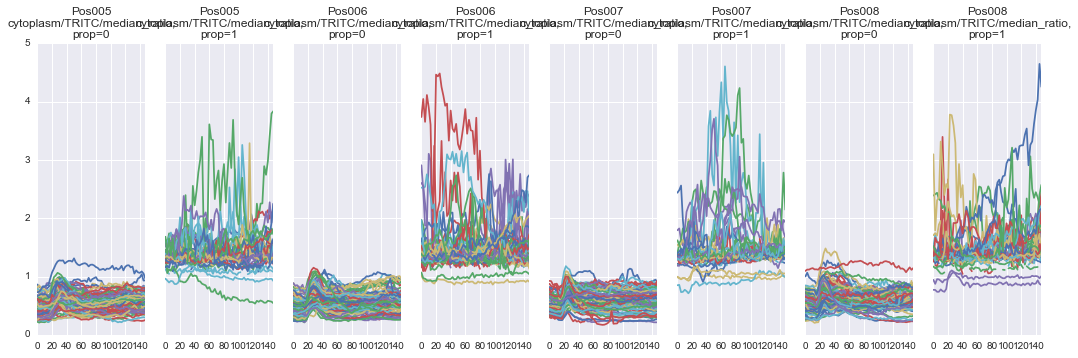

In [11]:
sites.set_state(['cytoplasm', 'TRITC', 'median_ratio'])
fig, axes = sites.iterate(plot_all)

We can now remove the cells with *pid = 1* and confirm that they were removed from the data set. The function *sites.drop_prop* removes all frames with the given *pid* and saves it to a new file. The modified file name is 'arr_modified.npz' by default. This can be changed using *sites.staged.new_file_name* (e.g. *sites.staged.new_file_name = 'new_file.npz'*) if you want to save multiple data sets. We recommend doing this frequently. 

Pos008: file_name is updated to arr_modified.npz


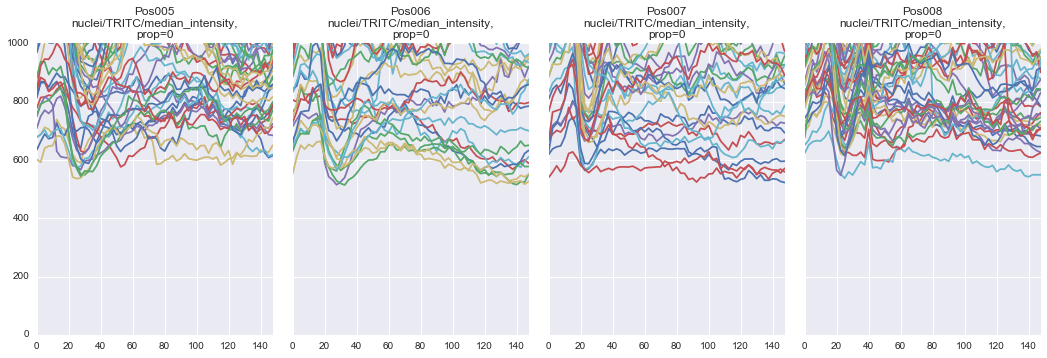

In [12]:
sites.drop_prop(1)
sites.set_state(['nuclei', 'TRITC', 'median_intensity'])
fig, axes = sites.iterate(plot_all)
[ax.set_ylim([0, 1000]) for ax in axes];

Another frequent cause of noisy data is errors in the image segmentation. Particularly when cells are confluent, it is sometimes hard to sample many pixels from cytoplasm, thus the data extracted may not be reliable. Therefore, we remove cells that have too few pixels. 

Use *sites.set_state* to select the cytoplasmic area, and *sites.iterate* to plot and mark the cells. Then use *sites.propagate_prop* and *sites.drop_prop* to remove these cells. 

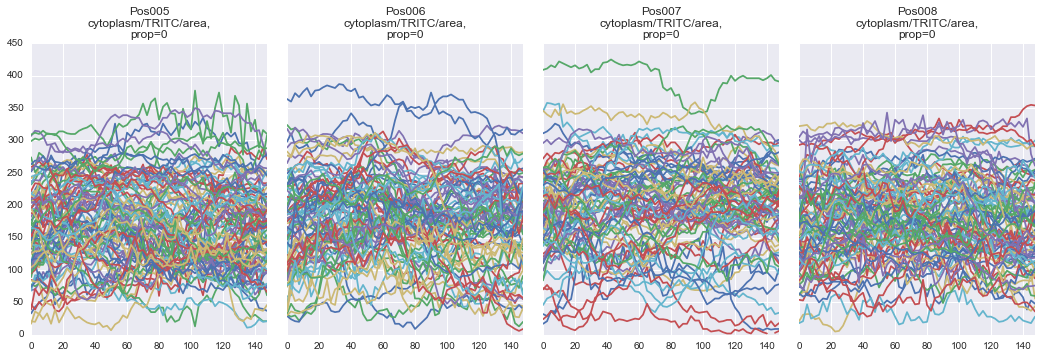

In [13]:
sites.set_state(['cytoplasm', 'TRITC', 'area'])
fig, axes = sites.iterate(plot_all)

In [14]:
op = partial(ops_bool.filter_frames_by_range, LOWER=50)
sites.iterate(op, 1)
sites.propagate_prop(pid=1)
sites.drop_prop(1)

Pos008: file_name is updated to arr_modified.npz


Run a similar operation for nuclear area. Too small or too big nuclei often mean segmentation error or unhealthy cells.

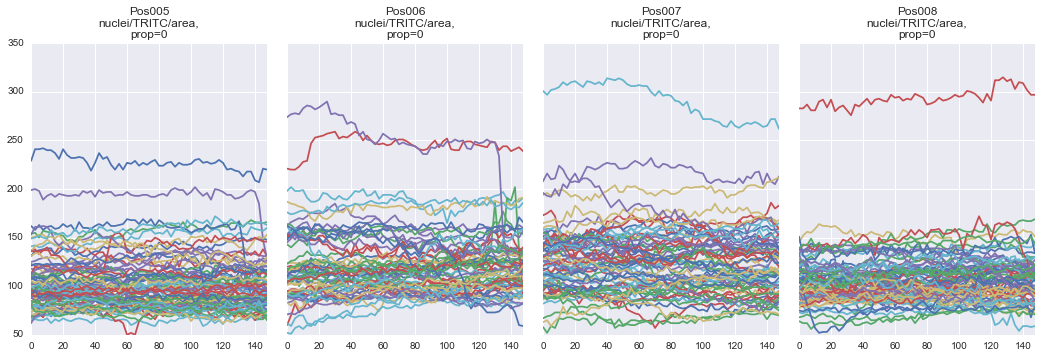

In [15]:
sites.set_state(['nuclei', 'TRITC', 'area'])
fig, axes = sites.iterate(plot_all)

In [16]:
op = partial(ops_bool.filter_frames_by_range, LOWER=60, UPPER=180)
sites.iterate(op, 1)
sites.propagate_prop(pid=1)
sites.drop_prop(1)

Pos008: file_name is updated to arr_modified.npz


Another frequent cause of noise is a sudden change in nuclear area. This may be caused by cell death, cell division, or mis-segmentation. Use the same process as above to remove cells with a sudden nuclear area change.  
Let's filter out cells if nuclear area changes more than 15 pixels. The function *ops_bool.filter_frames_by_diff* can be used to find cells with sudden area changes.

Pos008: file_name is updated to arr_modified.npz


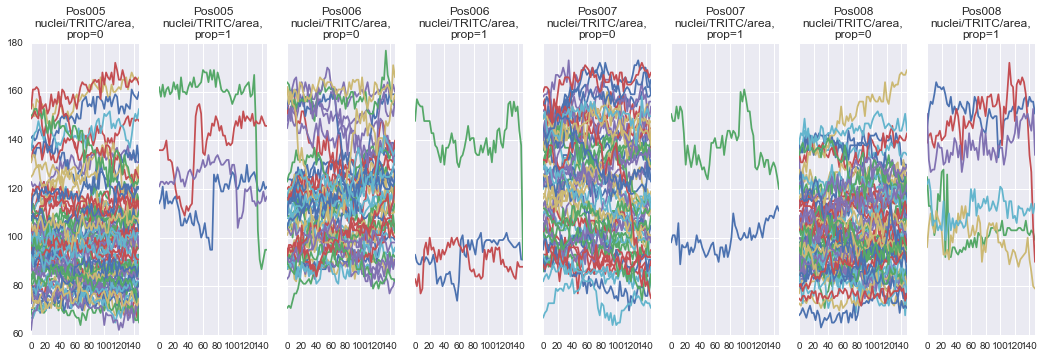

In [17]:
sites.reset_prop()
sites.set_state(['nuclei', 'TRITC', 'area'])
diff_filter = partial(ops_bool.filter_frames_by_diff, THRES=15)
sites.iterate(diff_filter, 1)
sites.propagate_prop(pid=1)
fig, axes = sites.iterate(plot_all)

In [18]:
sites.drop_prop(1)

Pos008: file_name is updated to arr_modified.npz


When the signal-to-noise ratio is low, noise in the measurements can drastically affect the normalization of normalize nuclear intensity by cytoplasmic intensity.
For simplicity, let's exclude cells which have expression levels outside of the 10th and 95th percentile in either nucleus or cytoplasm. This can be accomplished with the function *ops_bool.filter_frames_by_percentile_stats*. 

Here we use *sites.staged.new_file_name* to define a new name before removing the cells, so that the cleaned data set is saved for future access.

In [19]:
sites.set_state(['cytoplasm', 'TRITC', 'median_intensity'])
op = partial(ops_bool.filter_frames_by_percentile_stats, LOWER=10, UPPER=95)
sites.iterate(op, 1)
sites.set_state(['nuclei', 'TRITC', 'median_intensity'])
sites.iterate(op, 1)
sites.propagate_prop(pid=1)
sites.staged.new_file_name = 'df_cleaned.npz'
sites.drop_prop(1)

Pos008: file_name is updated to df_cleaned.npz


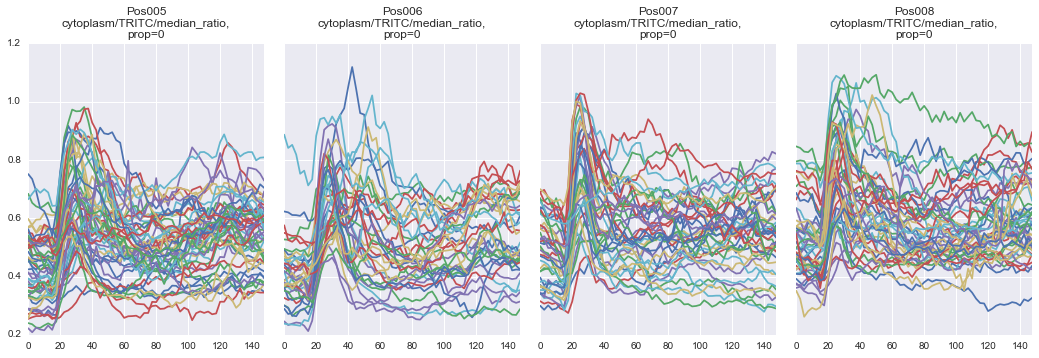

In [20]:
sites.set_state(['cytoplasm', 'TRITC', 'median_ratio']);
fig, axes = sites.iterate(plot_all)

Now the single-cell traces are significantly less noisy. 
You can use the Bokeh notebook below to zoom and pan to investigate the data closer.

In [21]:
import bokeh.io
bokeh.io.output_notebook()
import bokeh.mpl
import bokeh.plotting

Loading BokehJS ...

In [22]:
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites.iterate(plot_all)
fig.set_size_inches((4, 4))
bokeh.plotting.show(bokeh.mpl.to_bokeh())  # Add this line after you plot

/Users/kudo/.pyenv/versions/anaconda-2.4.0/envs/trace/lib/python2.7/site-packages/bokeh/io.py:350: UserWarning: 

BokehJS does not appear to have successfully loaded. If loading BokehJS from CDN, this
may be due to a slow or bad network connection. Possible fixes:

* ALWAYS run `output_notebook()` in a cell BY ITSELF, AT THE TOP, with no other code
* re-rerun `output_notebook()` to attempt to load from CDN again, or
* use INLINE resources instead, as so:

    from bokeh.resources import INLINE
    output_notebook(resources=INLINE)

  warnings.warn(_NB_LOAD_WARNING)


Now we went through the data cleaning. This is just one example for cleaning this dataset, and different experiments would need to go through different processes.     
A cleaning process requires the quick iterations of visualization and filtering for multiple wells.

### Clean the YFP channel

Before we move on to the next dataset, we will also do some cleaning on YFP channel.  
In this experiment, cells express JNKKTR AE mutant in YFP channel on top of the WT JNK KTR in TRITC channel.

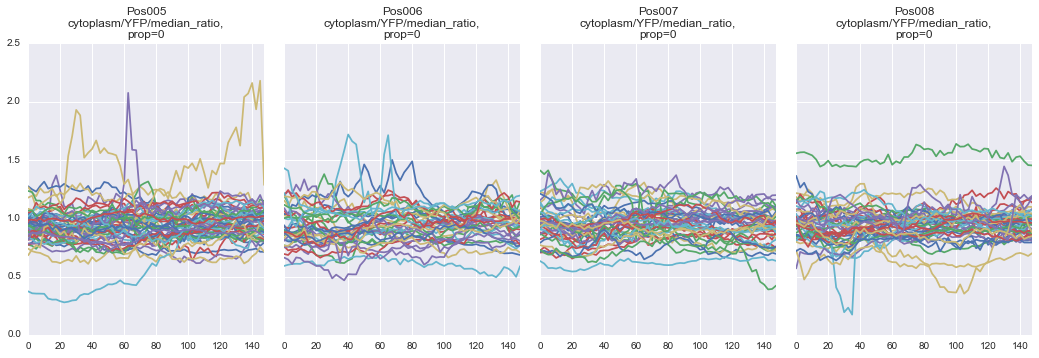

In [23]:
sites.set_state(['cytoplasm', 'YFP', 'median_ratio']);
fig, axes = sites.iterate(plot_all)

We will only be using the average trace for the JNK AE mutant when we start modeling, so filter out traces with outliers and drastic changes that will skew the average.

Pos008: file_name is updated to df_cleaned.npz


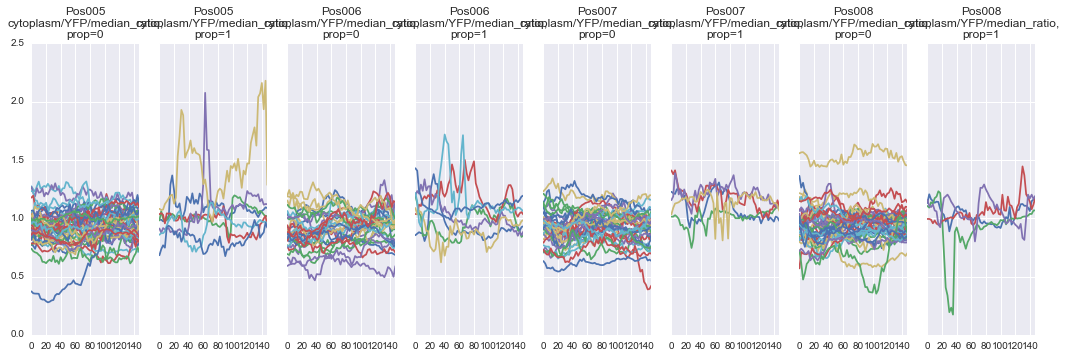

In [24]:
sites.set_state(['cytoplasm', 'YFP', 'median_ratio'])
diff_filter = partial(ops_bool.filter_frames_by_diff, PERIOD=1, THRES=0.15)
sites.iterate(diff_filter, 1)
sites.propagate_prop(pid=1)
fig, axes = sites.iterate(plot_all)

In [25]:
sites.drop_prop(1)

Pos008: file_name is updated to df_cleaned.npz


Pos008: file_name is updated to df_cleaned.npz


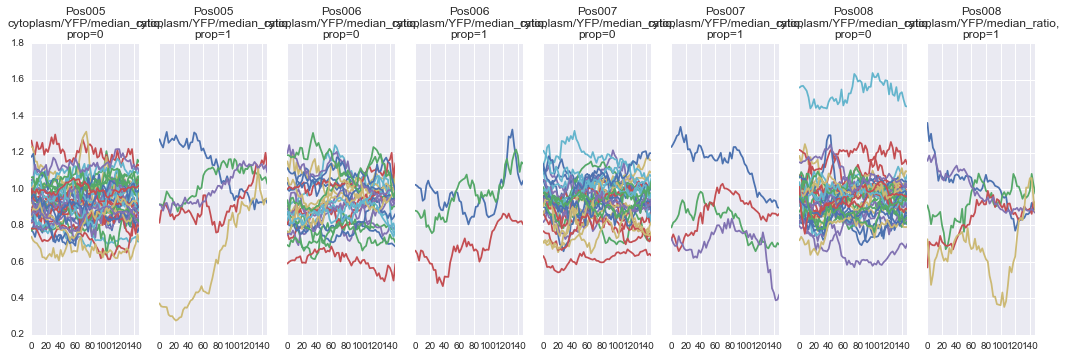

In [26]:
std_filter = partial(ops_bool.filter_frames_by_percentile_stats, func=np.nanstd, UPPER=90)
sites.iterate(std_filter, 1)
sites.propagate_prop(pid=1)
fig, axes = sites.iterate(plot_all)

In [27]:
sites.drop_prop(1)

Pos008: file_name is updated to df_cleaned.npz


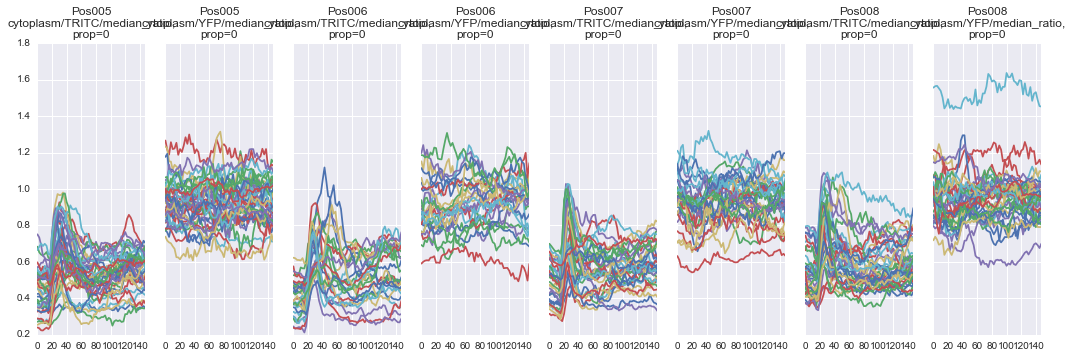

In [28]:
sites.set_state([['cytoplasm', 'TRITC', 'median_ratio'], ['cytoplasm', 'YFP', 'median_ratio']])
fig, axes = sites.iterate(plot_all)

### Clean the second dataset: Anisomycin stimulation followed by JNK inhibitor

We are going to use the same process to clean the other datasets that we need.  
Now we will clean the dataset where the JNK KTR was activated with anisomycin and then inactivated with JNK inhibitor.  
This time we have only one position.

In [58]:
parent_folder = join(data_folder, 'AnisoInh')
sub_folders = ['Pos001']
conditions = ['AnisoInh']
sites_anis = Sites(parent_folder, sub_folders, conditions, file_name='df.npz')

In [59]:
# Set a time stamp
sites_anis.Pos001.data.time = list(np.arange(29) * 5)  # every 5 min
sites_anis.Pos001.save()

Pos001: file_name is updated to arr_modified.npz


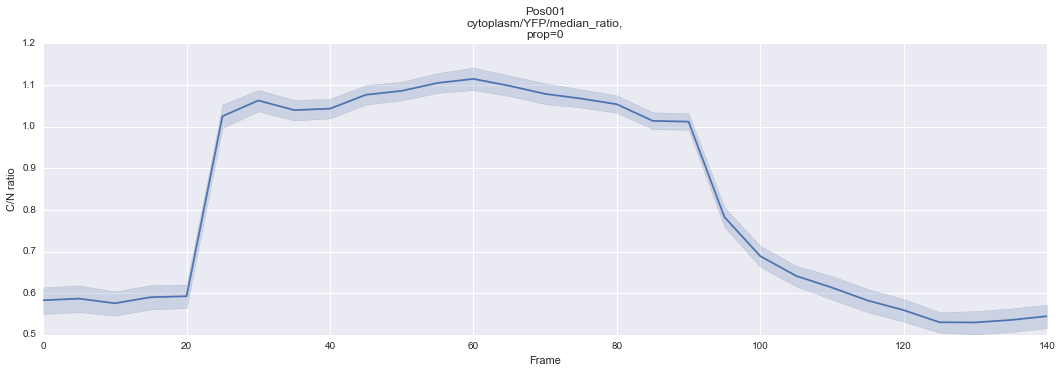

In [60]:
sites_anis.set_state(['cytoplasm', 'YFP', 'median_ratio'])
fig, axes = sites_anis.iterate(plot_tsplot)
[ax.set_xlabel('Frame') for ax in axes]
[ax.set_ylabel('C/N ratio') for ax in axes]

You can see the activation of JNK KTR followed by inhibition.

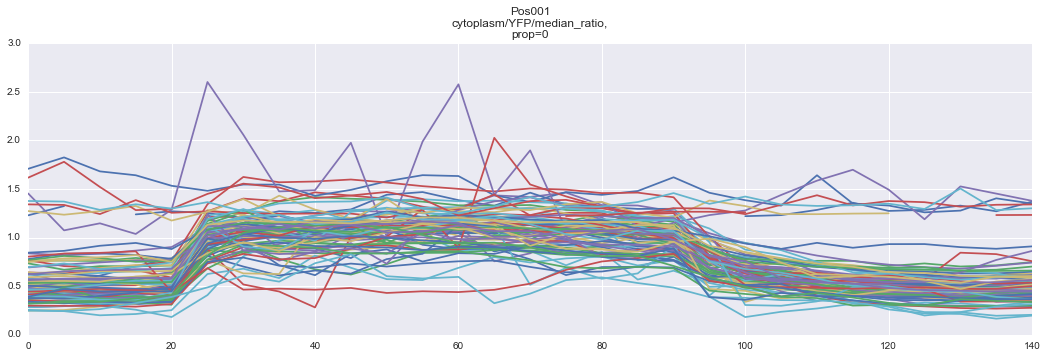

In [61]:
plot_all = partial(ops_plotter.plot_all)
fig, axes = sites_anis.iterate(plot_all)

Again, you see some outliers before cleaning.  
First remove cells without reporter expression.

[(888.0, 20000)]

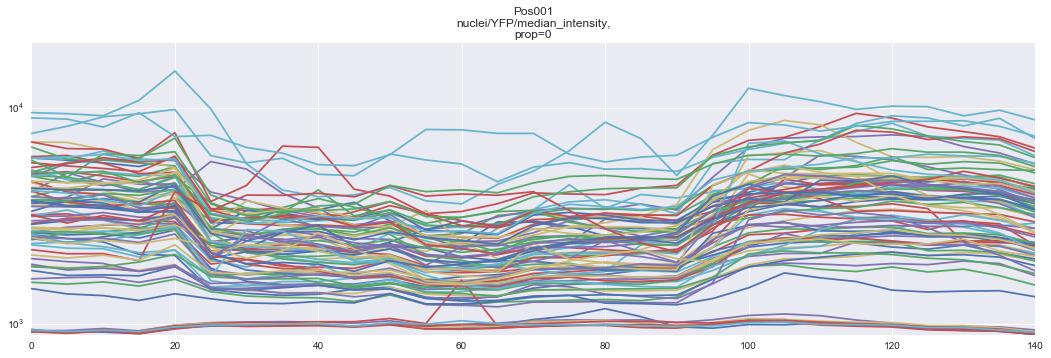

In [62]:
sites_anis.set_state(['nuclei', 'YFP', 'median_intensity'])
plot_all_log = partial(ops_plotter.plot_all, logy=True)
fig, axes = sites_anis.iterate(plot_all_log)
[ax.set_ylim([0, 20000]) for ax in axes]

Pos001: file_name is updated to arr_modified.npz


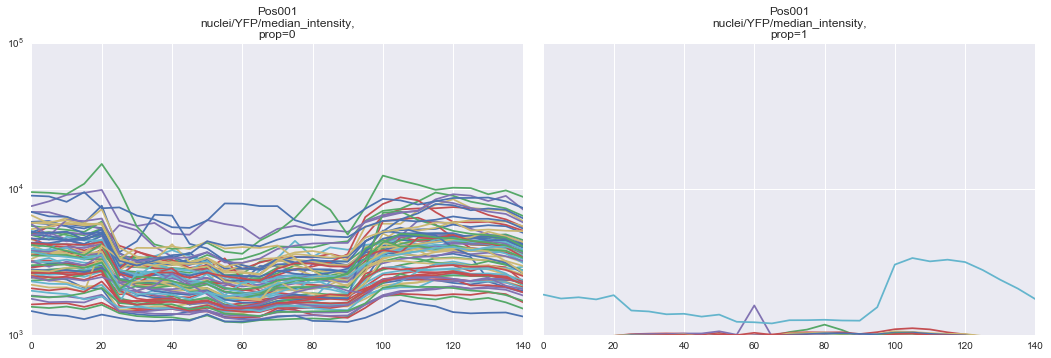

In [63]:
op = partial(ops_bool.filter_frames_by_range, LOWER=1200)
sites_anis.iterate(op, 1)
sites_anis.propagate_prop(pid=1)
fig, axes = sites_anis.iterate(plot_all_log)

In [64]:
sites_anis.drop_prop(1)

Pos001: file_name is updated to arr_modified.npz


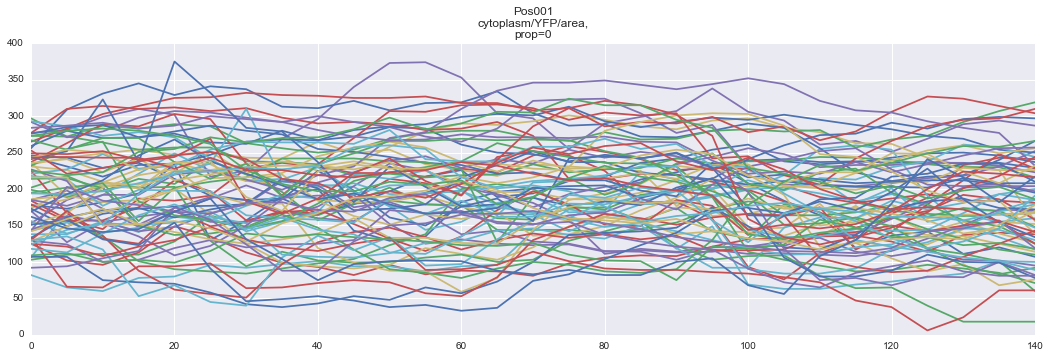

In [65]:
sites_anis.set_state(['cytoplasm', 'YFP', 'area'])
fig, axes = sites_anis.iterate(plot_all)

Drop cells which have less than 40 cytoplasmic pixels.

In [66]:
op = partial(ops_bool.filter_frames_by_range, LOWER=40)
sites_anis.iterate(op, 1)
sites_anis.propagate_prop(pid=1)
sites_anis.drop_prop(1)

Pos001: file_name is updated to arr_modified.npz


Detect sudden changes in nuclear area.

Pos001: file_name is updated to arr_modified.npz


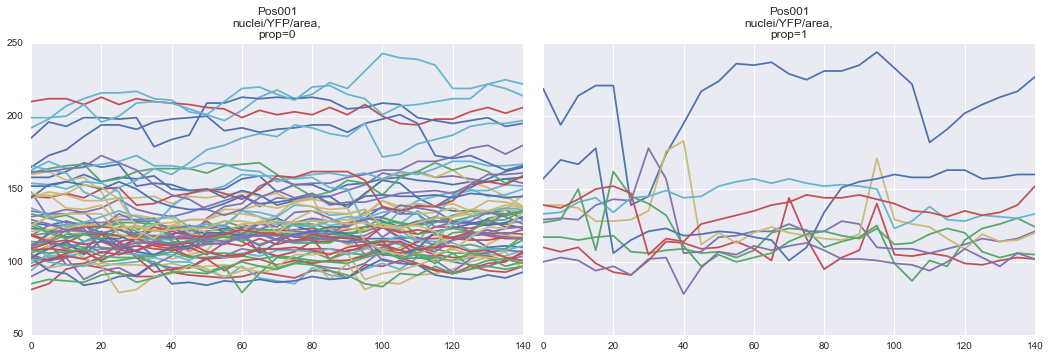

In [67]:
sites_anis.set_state(['nuclei', 'YFP', 'area'])
diff_filter = partial(ops_bool.calc_rolling_func_filter, threshold=15, window=5)
sites_anis.iterate(diff_filter, 1)
sites_anis.propagate_prop(pid=1)
fig, axes = sites_anis.iterate(plot_all)

In [39]:
sites_anis.drop_prop(1)

Pos001: file_name is updated to arr_modified.npz


Drop cells whose median intensity of either nuclei/cytoplasm are outside of 10 to 95 percentile.

In [68]:
sites_anis.set_state(['cytoplasm', 'YFP', 'median_intensity'])
op = partial(ops_bool.filter_frames_by_percentile_stats, LOWER=10, UPPER=95)
sites_anis.iterate(op, 1)
sites_anis.set_state(['nuclei', 'YFP', 'median_intensity'])
sites_anis.iterate(op, 1)
sites_anis.propagate_prop(pid=1)

sites_anis.staged.new_file_name = 'df_cleaned.npz'
sites_anis.drop_prop(1)

Pos001: file_name is updated to df_cleaned.npz


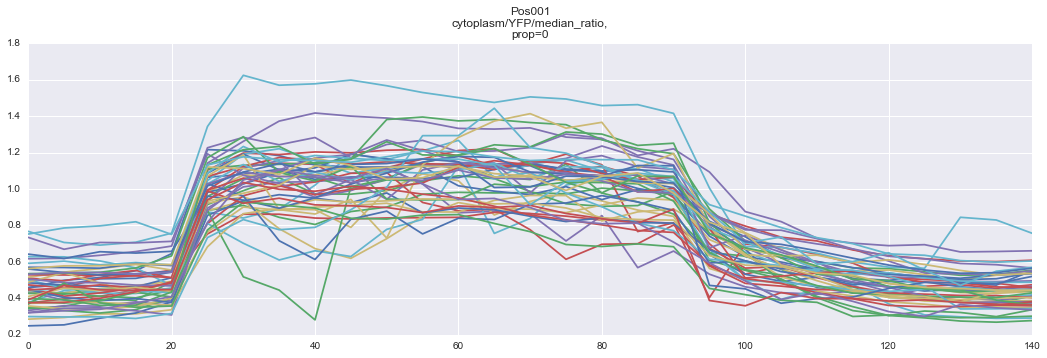

In [69]:
sites_anis.set_state(['cytoplasm', 'YFP', 'median_ratio'])
fig, axes = sites_anis.iterate(plot_all)

In [42]:
# op = partial(ops_bool.filter_frames_by_range, UPPER=4)
# sites_anis.iterate(op, 1)
# sites_anis.propagate_prop(pid=1)
# sites_anis.drop_prop(1)

Pos001: file_name is updated to df_cleaned.npz


### Clean the third dataset: Leptomycin B treatment of JNK KTR AA/EE mutants

We are going to use the same process to clean the other datasets that we need. 
In this dataset, there are two positions. One is JNKKTR AA mutants and the another is JNKKTR EE mutants.  
Cells were treated with Leptomycin B (LMB) at 2 min and 26 min for JNKKTR AA mutants and JNKKTR EE mutants, respectively.

Here we see that the *sites* class can store multiple positions and conditions.

In [43]:
parent_folder_mut = join(data_folder, 'LMB')
sub_folders_mut = ['Pos004', 'Pos005']
conditions_mut = ['JNK_AA', 'JNK_EE']
sites_mut = Sites(parent_folder_mut, sub_folders_mut, conditions_mut, file_name='df.npz')
# Set time stamps and save. 
sites_mut.Pos004.data.time = list(np.arange(0, 40) * 0.5)
sites_mut.Pos004.save()
sites_mut.Pos005.data.time = list(np.concatenate((np.arange(0, 28, 2), np.arange(28, 48.5, 0.5))))
sites_mut.Pos005.save()

Pos005: file_name is updated to arr_modified.npz


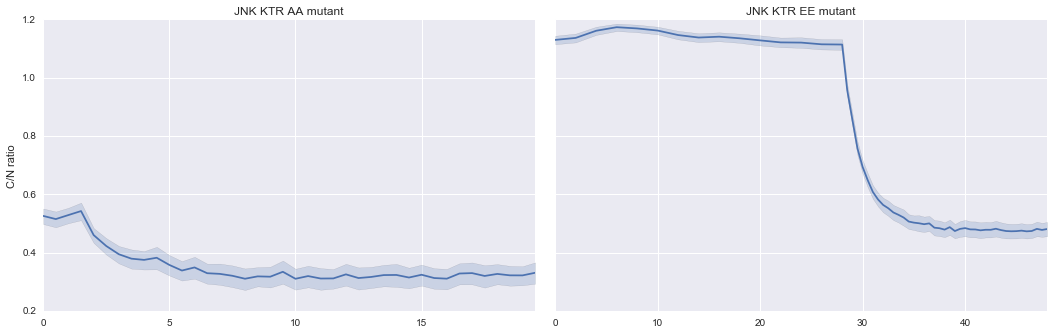

In [44]:
sites_mut.set_state(['cytoplasm', 'YFP', 'median_ratio'])
fig, axes = sites_mut.iterate(plot_tsplot)
axes[0].set_title('JNK KTR AA mutant')
axes[1].set_title('JNK KTR EE mutant')
axes[0].set_ylabel('C/N ratio')

The C/N ratio of JNK KTR EE mutants is almost equivalent to the active JNK KTR, indicating that it localizes to the cytoplasm more than JNK AA mutants do initially.  
After Leptomycin B treatment, you can see that inhibition of nuclear export leads to nuclear localization for both mutants.

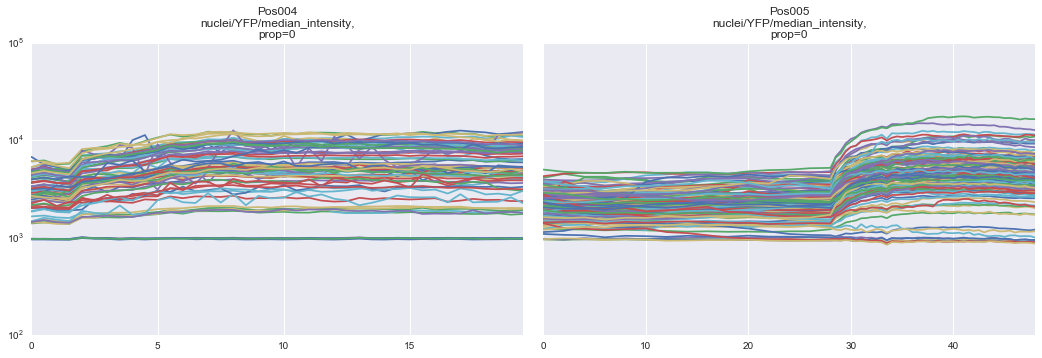

In [45]:
sites_mut.set_state(['nuclei', 'YFP', 'median_intensity'])
fig, axes = sites_mut.iterate(plot_all_log)

Now we can again exclude cells with low reporter expression levels, small nuclear areas, and sudden changes in nuclear area.

In [46]:
op = partial(ops_bool.filter_frames_by_range, LOWER=3000, FRAME_START=30)
sites_mut.iterate(op, 1)
sites_mut.propagate_prop(pid=1)
sites_mut.drop_prop(1)

Pos005: file_name is updated to arr_modified.npz


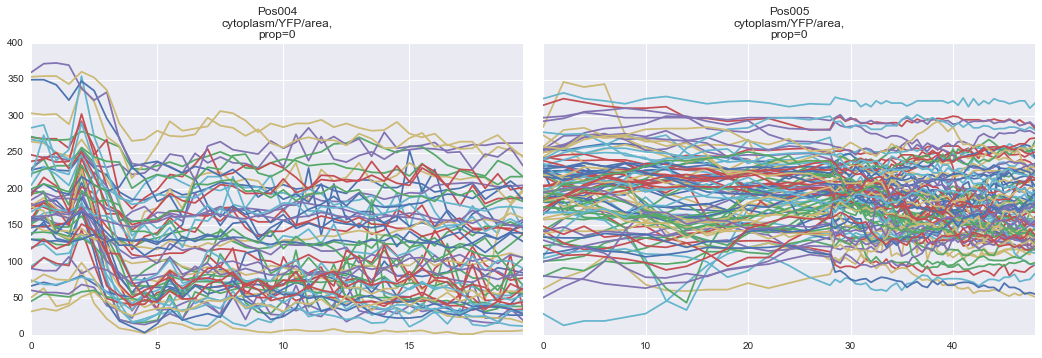

In [47]:
sites_mut.set_state(['cytoplasm', 'YFP', 'area'])
fig, axes = sites_mut.iterate(plot_all)

In [48]:
op = partial(ops_bool.filter_frames_by_range, LOWER=50)
sites_mut.iterate(op, 1)
sites_mut.propagate_prop(pid=1)
sites_mut.drop_prop(1)

Pos005: file_name is updated to arr_modified.npz


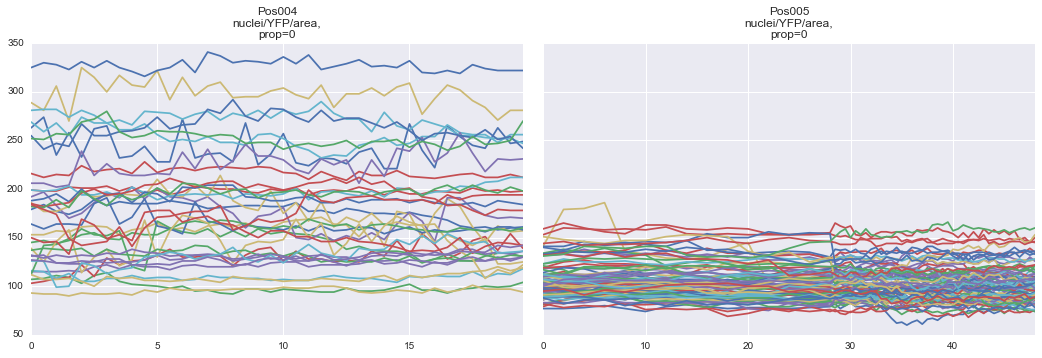

In [49]:
sites_mut.set_state(['nuclei', 'YFP', 'area'])
fig, axes = sites_mut.iterate(plot_all)

In [50]:
diff_filter = partial(ops_bool.calc_rolling_func_filter, threshold=15, window=5)
sites_mut.iterate(diff_filter, 1)
sites_mut.propagate_prop(pid=1)
sites_mut.drop_prop(pid=1)

Pos005: file_name is updated to arr_modified.npz


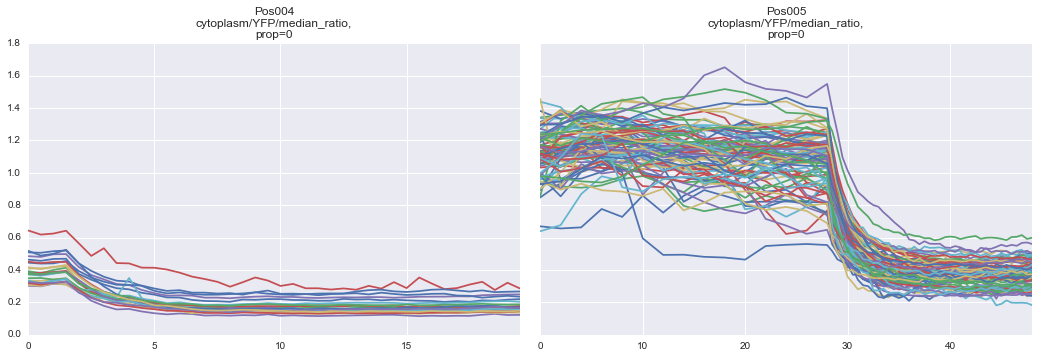

In [51]:
sites_mut.set_state(['cytoplasm', 'YFP', 'median_ratio'])
fig, axes = sites_mut.iterate(plot_all)

In [52]:
sites_mut.staged.new_file_name = 'df_cleaned.npz'
op = partial(ops_bool.filter_frames_by_range, UPPER=0.6, FRAME_START=35)
sites_mut.iterate(op, 1)
sites_mut.propagate_prop(pid=1)
sites_mut.drop_prop(1)

Pos005: file_name is updated to df_cleaned.npz


In [53]:
sites_mut.set_state(['cytoplasm', 'YFP', 'median_intensity'])
op = partial(ops_bool.filter_frames_by_percentile_stats, LOWER=10, UPPER=95)
sites_mut.iterate(op, 1)
sites_mut.set_state(['nuclei', 'YFP', 'median_intensity'])
sites_mut.iterate(op, 1)
sites_mut.propagate_prop(pid=1)
sites_mut.staged.new_file_name = 'df_cleaned.npz'
sites_mut.drop_prop(1)

Pos005: file_name is updated to df_cleaned.npz


The cleaned single-cell traces are noticeably less noisy than before.

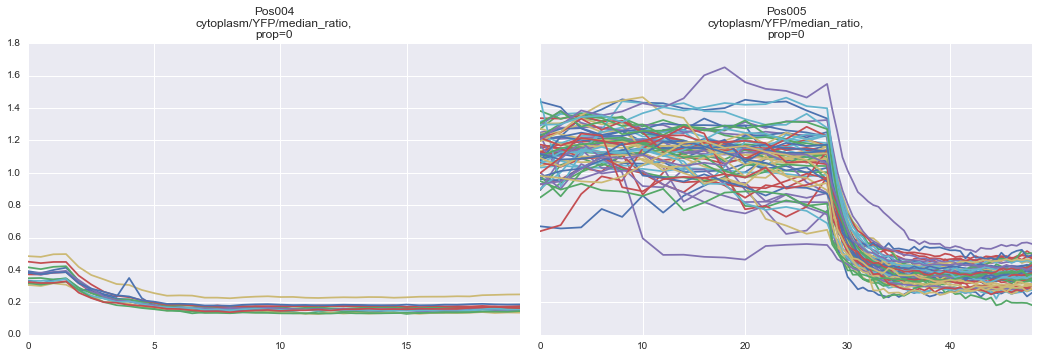

In [54]:
sites_mut.set_state(['cytoplasm', 'YFP', 'median_ratio'])
fig, axes = sites_mut.iterate(plot_all)